In [170]:
from surprise import Dataset
import pandas as pd
from surprise import Dataset, Reader
from surprise import Reader
from surprise import SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import cross_validate, GridSearchCV
import pickle
import pyarrow.parquet as pq
import pyarrow as pa

In [171]:
df_steam_games_ml = pd.read_parquet('Data/steam_games_ml.parquet')
df_user_reviews_ml = pd.read_parquet('Data/user_reviews.parquet')

In [172]:
df = pd.merge(df_user_reviews_ml[['item_id','user_id','recommend','sentiment_analysis']], df_steam_games_ml[['item_id','app_name']], left_on='item_id', right_on='item_id')


In [173]:
df

,item_id,user_id,recommend,sentiment_analysis,app_name
0,1250,76561197970982479,True,2,Killing Floor
1,1250,death-hunter,True,2,Killing Floor
2,1250,DJKamBer,True,0,Killing Floor
3,1250,diego9031,True,2,Killing Floor
4,1250,76561198081962345,True,2,Killing Floor
...,...,...,...,...,...
40414,367780,laislabonita75,True,2,Aero's Quest
40415,367780,evilindiegaming,True,2,Aero's Quest
40416,305920,laislabonita75,False,0,Another Perspective
40417,306040,Gamer0009,True,2,The Howler


In [174]:
for index, row in df.iterrows():
    if (row[2] == True) and (row[3] == 2):
        df.loc[index, 'rating'] = 5.0
        
    elif (row[2] == True) and (row[3] == 1):
        df.loc[index, 'rating'] = 4.0
        
    elif (row[2] == True) and (row[3] == 0):
        df.loc[index, 'rating'] = 3.0
        
    elif (row[2] == False) and (row[3] == 2):
        df.loc[index, 'rating'] = 2.0
        
    elif (row[2] == False) and (row[3] == 1):
        df.loc[index, 'rating'] = 1.0
        
    elif (row[2] == False) and (row[3] == 0):
        df.loc[index, 'rating'] = 0.0


C:\Users\joaqu\AppData\Local\Temp\ipykernel_7312\1732854565.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (row[2] == True) and (row[3] == 2):
C:\Users\joaqu\AppData\Local\Temp\ipykernel_7312\1732854565.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (row[2] == True) and (row[3] == 2):
C:\Users\joaqu\AppData\Local\Temp\ipykernel_7312\1732854565.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif (row[2] == True) 

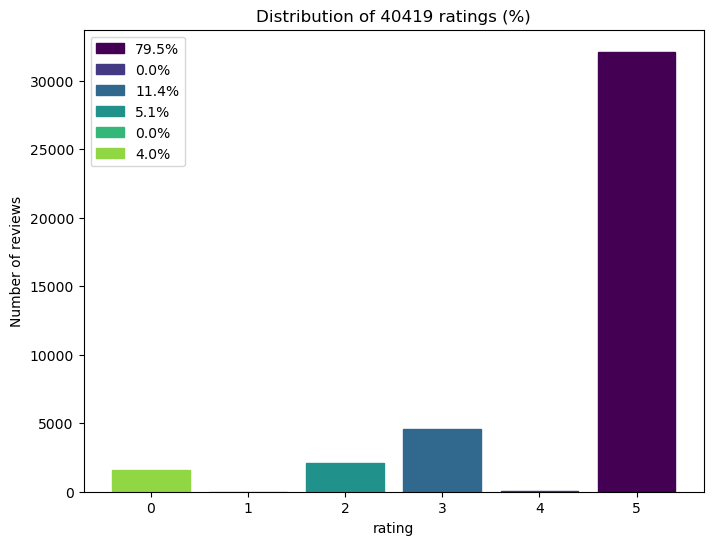

In [175]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

# Calculate the distribution of sentiments
data = df['rating'].value_counts().sort_index(ascending=False)
percentage_data = (data / df.shape[0] * 100)

colors = plt.get_cmap('viridis')

# Create the figure with Matplotlib
plt.figure(figsize=(8, 6))
bars = plt.bar(data.index, data.values)
plt.xlabel('rating')
plt.ylabel('Number of reviews')
plt.title('Distribution of {} ratings (%)'.format(df.shape[0]))

for i, (bar, v) in enumerate(zip(bars, percentage_data)):
    bar.set_color(colors(i / len(data)))
    bar.set_label('{:.1f}%'.format(v))

plt.legend(loc='upper left')
plt.show()


In [176]:
df.head()

,item_id,user_id,recommend,sentiment_analysis,app_name,rating
0,1250,76561197970982479,True,2,Killing Floor,5.0
1,1250,death-hunter,True,2,Killing Floor,5.0
2,1250,DJKamBer,True,0,Killing Floor,3.0
3,1250,diego9031,True,2,Killing Floor,5.0
4,1250,76561198081962345,True,2,Killing Floor,5.0


In [177]:
train_data= df[['user_id','app_name','rating']]
train_data

,user_id,app_name,rating
0,76561197970982479,Killing Floor,5.0
1,death-hunter,Killing Floor,5.0
2,DJKamBer,Killing Floor,3.0
3,diego9031,Killing Floor,5.0
4,76561198081962345,Killing Floor,5.0
...,...,...,...
40414,laislabonita75,Aero's Quest,5.0
40415,evilindiegaming,Aero's Quest,5.0
40416,laislabonita75,Another Perspective,0.0
40417,Gamer0009,The Howler,5.0


# SVD

In [178]:
# Define a reader for your data format
reader = Reader(rating_scale=(0, 5))  # Adapt rating_scale to your data

# Load the data using the reader
data = Dataset.load_from_df(train_data, reader)

# Split the dataset into training and test sets
train_set, test_set = train_test_split(data, test_size=0.25)  # You can adjust the test size

# Select an algorithm (e.g., SVD) and train the model
svd_algo = SVD(n_factors=50, n_epochs=30, biased=True, lr_all=0.005, reg_all=0.1, random_state=42)
svd_algo.fit(train_set)

# Make predictions on the test set
test_pred = svd_algo.test(test_set)

print("SVD: Test Set")
accuracy.rmse(test_pred, verbose=True)

print("\n")

print("SVD: Training Set")
training_pred = svd_algo.test(train_set.build_testset())
accuracy.rmse(training_pred, verbose=True)


SVD: Test Set
RMSE: 1.1914


SVD: Training Set
RMSE: 0.8800


0.8799565433560482

- Ajuste Hiperparámetros SVD

In [179]:
# Hyperparameter tuning
param_grid = {'n_factors': [5, 50, 100, 120], 'n_epochs': [5, 10, 20, 35], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2]}

# Perform grid search to find the best hyperparameters
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
gs.fit(data)



In [180]:
print("Best value for RMSE", gs.best_score['rmse'])

Best value for RMSE 1.2066206586239951


In [181]:
print("Best hiperparameters:", gs.best_params['rmse'])

Best hiperparameters: {'n_factors': 5, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.2}


In [182]:
best_svd= gs.best_estimator['rmse']

In [183]:
# Cross-validation of the SVD algorithm on 10 partitions
print("Cross-validation of the SVD algorithm on 10 partitions")
cross_validate(best_svd, data, measures=['RMSE', 'MAE'], cv=10, verbose=True)


Cross-validation of the SVD algorithm on 10 partitions
Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    1.1968  1.2260  1.2381  1.2192  1.1719  1.2110  1.2157  1.1578  1.1665  1.2011  1.2004  0.0256  
MAE (testset)     0.8329  0.8517  0.8541  0.8395  0.8223  0.8366  0.8447  0.8097  0.8183  0.8294  0.8339  0.0137  
Fit time          0.06    0.06    0.06    0.06    0.06    0.06    0.06    0.06    0.07    0.06    0.06    0.00    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.01    0.01    0.01    0.01    0.01    0.00    


{'test_rmse': array([1.19677704, 1.22598169, 1.23814934, 1.2191878 , 1.17185157,
        1.21096733, 1.21574107, 1.15775827, 1.16648139, 1.20109334]),
 'test_mae': array([0.83294679, 0.85173906, 0.85406573, 0.83953521, 0.82229317,
        0.8365934 , 0.84469158, 0.80969297, 0.8182865 , 0.82941122]),
 'fit_time': (0.06399941444396973,
  0.05999922752380371,
  0.06400012969970703,
  0.06099987030029297,
  0.06199979782104492,
  0.059999942779541016,
  0.06399989128112793,
  0.06300067901611328,
  0.06700015068054199,
  0.060999393463134766),
 'test_time': (0.00800013542175293,
  0.008999824523925781,
  0.008999824523925781,
  0.007999897003173828,
  0.007999897003173828,
  0.007999897003173828,
  0.00800013542175293,
  0.007999420166015625,
  0.007999897003173828,
  0.009000062942504883)}

## Model with better hiperparameters

In [184]:
# Define a reader for your data
reader2 = Reader(rating_scale=(0, 5))  # Adapt rating_scale to your data

# Load the data using the reader
data2 = Dataset.load_from_df(train_data, reader2)

# Split the dataset into training and test sets with a specified random seed
train_set, test_set = train_test_split(data2, test_size=0.25, random_state=42)  # You can adjust the test size

# Select an algorithm (e.g., SVD) and train the model
svd_algo2 = SVD(n_factors=120, n_epochs=35, lr_all=0.005, reg_all=0.2)

# Perform cross-validation with the algorithm
cross_validate(svd_algo2, data2, measures=['RMSE', 'MAE'], cv=7, verbose=True)

# Fit the model on the training set
svd_algo2.fit(train_set)

# Make predictions on the test set
test_pred2 = svd_algo2.test(test_set)

print("SVD: Test Set")
accuracy.rmse(test_pred2, verbose=True)

print("\n")

print("SVD: Training Set")
training_pred2 = svd_algo2.test(train_set.build_testset())
accuracy.rmse(training_pred2, verbose=True)


Evaluating RMSE, MAE of algorithm SVD on 7 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Mean    Std     
RMSE (testset)    1.2104  1.1850  1.2240  1.2144  1.2248  1.1948  1.1770  1.2044  0.0176  
MAE (testset)     0.8481  0.8268  0.8464  0.8404  0.8411  0.8267  0.8153  0.8350  0.0113  
Fit time          0.33    0.32    0.32    0.31    0.34    0.33    0.33    0.33    0.01    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.01    0.01    0.00    
SVD: Test Set
RMSE: 1.1867


SVD: Training Set
RMSE: 0.8182


0.8181663803478417

In [185]:
with open('Data/model.pkl', 'wb') as archivo:
    pickle.dump(svd_algo2, archivo)
    

In [186]:
with open ('Data/model.pkl', 'rb') as archivo:
    model = pickle.load(archivo)

In [187]:
def recommend_games(user_id):
    dictionary = {}
    # Create a list of games already rated by the specific user
    rated_games = df[df['user_id'] == user_id]['app_name'].unique()

    # Create a list of all available games
    all_games = df['app_name'].unique()

    # Create a list of games not rated by the specific user
    unrated_games = list(set(all_games) - set(rated_games))

    # Generate predictions for games not rated by the user
    predictions = [model.predict(user_id, game) for game in unrated_games]

    # Sort predictions based on rating and get the recommended games
    recommendations = sorted(predictions, key=lambda x: x.est, reverse=True)[:5]  # Get the top 5 recommendations

    # Show the recommended games
    game_list = []
    for recommendation in recommendations:
        game_list.append(recommendation.iid)

    for i, game in enumerate(game_list, start=1):
        option = f"option{i}"
        dictionary[option] = game

    if user_id not in df['user_id'].unique():
        return "User does not exist"
    else:
        return dictionary

 

In [188]:
recomendar_peliculas('JunG00berfuckingsucks')

{'opcion1': 'S.T.A.L.K.E.R.: Call of Pripyat',
 'opcion2': 'FINAL FANTASY VII',
 'opcion3': "Tom Clancy's Splinter Cell Chaos Theory®",
 'opcion4': 'Thief™ Gold',
 'opcion5': 'Batman: Arkham City - Game of the Year Edition'}

In [189]:
recomendar_peliculas('Gamer0009')

{'opcion1': 'You Have to Win the Game',
 'opcion2': 'Tropico 4',
 'opcion3': 'Human Resource Machine',
 'opcion4': 'METAL GEAR SOLID V: GROUND ZEROES',
 'opcion5': 'Worms Revolution'}

In [190]:
recomendar_peliculas('laislabonita75')

{'opcion1': 'DLC Quest',
 'opcion2': 'Age of Empires® III: Complete Collection',
 'opcion3': 'Solar 2',
 'opcion4': 'Rochard',
 'opcion5': 'The Expendabros'}

In [191]:
# Fit the best SVD model on the full training dataset
best_svd.fit(data.build_full_trainset())

# Make predictions on the test set
test_pred = best_svd.test(test_set)

print("SVD: Test Set")
accuracy.rmse(test_pred, verbose=True)

print("\n")

print("SVD: Training Set")
training_pred = best_svd.test(train_set.build_testset())
accuracy.rmse(training_pred, verbose=True)


SVD: Test Set
RMSE: 1.0472


SVD: Training Set
RMSE: 1.0722


1.0721709314148304

In [192]:
best_svd.predict(uid='76561197970982479', iid='Killing Floor', r_ui=5.0)

Prediction(uid='76561197970982479', iid='Killing Floor', r_ui=5.0, est=4.614853311094266, details={'was_impossible': False})

In [193]:
train_data.head(1)

,user_id,app_name,rating
0,76561197970982479,Killing Floor,5.0


In [194]:
def get_prediction(row):
    user_id = row['user_id']
    item_id = row['item_id']
    prediction = best_svd.predict(uid=user_id, iid=item_id)
    return prediction.est

# Apply the prediction retrieval function to each row in the DataFrame
df['predictions'] = df.apply(get_prediction, axis=1)



In [195]:
df

,item_id,user_id,recommend,sentiment_analysis,app_name,rating,predictions
0,1250,76561197970982479,True,2,Killing Floor,5.0,4.510922
1,1250,death-hunter,True,2,Killing Floor,5.0,4.545006
2,1250,DJKamBer,True,0,Killing Floor,3.0,4.401391
3,1250,diego9031,True,2,Killing Floor,5.0,4.722680
4,1250,76561198081962345,True,2,Killing Floor,5.0,4.466059
...,...,...,...,...,...,...,...
40414,367780,laislabonita75,True,2,Aero's Quest,5.0,4.094819
40415,367780,evilindiegaming,True,2,Aero's Quest,5.0,4.469986
40416,305920,laislabonita75,False,0,Another Perspective,0.0,4.094819
40417,306040,Gamer0009,True,2,The Howler,5.0,4.471451


### Save as a parquet

In [196]:
df.to_parquet('Data/ML_1.parquet')

In [197]:
# Filter predictions only for the specific user
user_predictions = df[df['user_id'] == '76561198081962345']

# Filter games not seen by the user
unseen_games = df[~df['item_id'].isin(user_predictions['item_id'])]

# Sort predictions in descending order
unseen_games = unseen_games.sort_values(by='predictions', ascending=False)

# Select the top 5 games for recommendations
top_recommendations = unseen_games.head(5)

# Print the recommendations
print("Top 5 Recommendations:")
game_list = []
for index, row in top_recommendations.iterrows():
    game_list.append(row['app_name'])
print(game_list)


Top 5 Recommendations:
['Dirty Bomb®', 'Hydrophobia: Prophecy', 'Sniper: Ghost Warrior', 'Call of Duty®: Advanced Warfare - Gold Edition', 'Call of Duty®: Black Ops II']


In [198]:
filtro= df.loc[df['user_id'] == '76561198081962345']
filtro

,item_id,user_id,recommend,sentiment_analysis,app_name,rating,predictions
4,1250,76561198081962345,True,2,Killing Floor,5.0,4.466059


Top 5 Recomendaciones:
Spiral Knights 4.823347712736086
METAL GEAR SOLID V: THE PHANTOM PAIN 4.823347712736086
The Evil Within 4.823347712736086
Call of Duty®: Advanced Warfare - Gold Edition 4.823347712736086
Assassin's Creed® Unity 4.823347712736086

In [199]:
with open('Data/modelo_final.pkl', 'wb') as file:
    pickle.dump(best_svd, file)

In [200]:
test= pd.read_parquet('Data/ML.parquet')

In [201]:
test

,item_id,user_id,recommend,sentiment_analysis,app_name,rating,predictions
0,1250,76561197970982479,True,2,Killing Floor,5.0,4.410874
1,1250,death-hunter,True,2,Killing Floor,5.0,4.496091
2,1250,DJKamBer,True,0,Killing Floor,3.0,4.308860
3,1250,diego9031,True,1,Killing Floor,4.0,4.237986
4,1250,76561198081962345,True,1,Killing Floor,4.0,4.174789
...,...,...,...,...,...,...,...
41609,367780,laislabonita75,True,2,Aero's Quest,5.0,3.848902
41610,367780,evilindiegaming,True,2,Aero's Quest,5.0,4.330905
41611,305920,laislabonita75,False,0,Another Perspective,0.0,3.848902
41612,306040,Gamer0009,True,2,The Howler,5.0,4.308333


In [202]:
def user_recommendation(user_id):
    
    user_predictions = test[test['user_id'] == user_id]

    # Filter games not seen by the user
    unseen_games = test[~test['item_id'].isin(user_predictions['item_id'])]

    # Sort predictions in descending order
    unseen_games = unseen_games.sort_values(by='predictions', ascending=False)

    # Select the top 5 game recommendations
    top_recommendations = unseen_games.head(5)

    # Print the recommendations
    game_list = []

    # Suppose that top_recommendations is a pandas DataFrame
    for _, row in top_recommendations.iterrows():
        game_list.append(row['app_name'])

    dictionary = {}

    for i, game in enumerate(game_list, start=1):
        option = f"option{i}"
        dictionary[option] = game

    return dictionary


In [203]:
user_recommendation('Whackky')

{'option1': 'Rust',
 'option2': "Five Nights at Freddy's",
 'option3': 'Counter-Strike',
 'option4': 'Loadout',
 'option5': 'Heroes & Generals'}

In [204]:
user_recommendation('Sp3ctre')

{'option1': 'Loadout',
 'option2': 'Rust',
 'option3': 'Heroes & Generals',
 'option4': 'Counter-Strike',
 'option5': 'Codename CURE'}

In [205]:
user_recommendation('spazrael_')

{'option1': "Garry's Mod",
 'option2': 'Heroes & Generals',
 'option3': 'Loadout',
 'option4': 'Counter-Strike',
 'option5': 'Codename CURE'}

# KNN

In [206]:
from surprise import KNNBasic

# Define a reader for your data format
reader = Reader(rating_scale=(0, 5))  # Adapt rating_scale to your data

# Load the data using the reader
data = Dataset.load_from_df(train_data, reader)

# Split the dataset into training and test sets
trainset, testset = train_test_split(data, test_size=0.25)  # You can adjust the test size

# Select an algorithm (e.g., KNN) and train the model
model2 = KNNBasic()  # Select the KNN algorithm
model2.fit(trainset)

# Make predictions on the test set
predictions = model2.test(testset)

# Evaluate the predictions
accuracy.rmse(predictions)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.3311


1.3310781133126373

In [207]:
# User ID for which you want recommendations
specific_user = '76561197970982479'  # Replace 'js41637' with the user's ID for whom you want recommendations

# Create a list of games already rated by the specific user
rated_games = train_data[train_data['user_id'] == specific_user]['app_name'].unique()

# Create a list of all available games
all_games = train_data['app_name'].unique()

# Create a list of games not rated by the specific user
unrated_games = list(set(all_games) - set(rated_games))

# Generate predictions for games not rated by the user
predictions = [model.predict(specific_user, game) for game in unrated_games]

# Sort predictions based on rating and get the recommended games (top 10)
recommendations = sorted(predictions, key=lambda x: x.est, reverse=True)[:10]

# Display the recommended games
for recommendation in recommendations:
    print(f"Game: {recommendation.iid}, Estimated Rating: {recommendation.est}")


Game: RWBY: Grimm Eclipse, Estimated Rating: 5
Game: Bastion, Estimated Rating: 5
Game: Turbo Dismount™, Estimated Rating: 5
Game: ENSLAVED™: Odyssey to the West™ Premium Edition, Estimated Rating: 5
Game: Age of Empires® III: Complete Collection, Estimated Rating: 5
Game: FINAL FANTASY VII, Estimated Rating: 5
Game: Tropico 4, Estimated Rating: 5
Game: The Swapper, Estimated Rating: 5
Game: Rogue Legacy, Estimated Rating: 5
Game: Assassin’s Creed® Brotherhood, Estimated Rating: 4.997203792497966
